## Nutrient Limitation

From [issue ticket](https://github.com/marbl-ecosys/cesm2-marbl/issues/5), we want

> Compute biomass-weighted-mean limitation terms in the upper ocean (i.e., top 150 m).
> 
> Make 3 panel plot: maps of most limiting nutrient for each phytoplankton taxa (diatom, small phyto, diazotrophs).

Process (from that same link):

> 1. Compute vertical, biomass-weighted mean limitation term for N, P, Si, Fe for each taxa yielding an array with [time, lim_term, lat, lon] dims.
> 2. Average in time, yielding a lim_term, lat, lon] dims.
> 3. Find the index of the min over the first dimension, yielding a 2D array.

In [1]:
%matplotlib inline
import os

import cftime

import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import cartopy
import cartopy.crs as ccrs

import intake
import intake_esm
import ann_avg_utils as aau

import ncar_jobqueue
from dask.distributed import Client

import xpersist as xp
# Set up xperist cache
cache_dir = os.path.join(os.path.sep, 'glade', 'p', 'cgd', 'oce', 'projects', 'cesm2-marbl', 'xpersist_cache')
if (os.path.isdir(cache_dir)):
    xp.settings['cache_dir'] = cache_dir
xp_dir = 'nutrient_limitation'
os.makedirs(os.path.join(xp.settings['cache_dir'], xp_dir), exist_ok=True)

%load_ext watermark
%watermark -a "Mike Levy" -d -iv -m -g -h

xpersist      0.0.post25
cartopy       0.17.0
cftime        1.0.3.4
ncar_jobqueue 2020.3.4
xarray        0.15.0
numpy         1.18.1
intake_esm    2020.3.16.2.post4
intake        0.5.4
Mike Levy 2020-04-01 

compiler   : GCC 7.3.0
system     : Linux
release    : 3.10.0-693.21.1.el7.x86_64
machine    : x86_64
processor  : x86_64
CPU cores  : 72
interpreter: 64bit
host name  : casper21
Git hash   : 7801d2039f61623e6915aa8a3b25042611702b06


In [2]:
cluster = ncar_jobqueue.NCARCluster(project='P93300606')
cluster.adapt(minimum_jobs=0, maximum_jobs=4)
client = Client(cluster)
client

Client Scheduler: tcp://10.12.205.30:39675 Dashboard: https://jupyterhub.ucar.edu/dav/user/mlevy/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [3]:
global_vars = aau.global_vars()

exp = 'cesm2_hist'
time_slices = global_vars['time_slices']
experiment_dict = global_vars['experiment_dict']

In [4]:
%%time

def _get_all_limitation_vars(autotroph):
    catalog = intake.open_esm_datastore('data/campaign-cesm2-cmip6-timeseries.json')

    darrays = []
    nutrient_dim = []
    for nutrient in nutrients:
        if (autotroph, nutrient) not in omit:
            var = f'{autotroph}_{nutrient}_lim_Cweight_avg_100m'
            print(f'Reading data for {var}')
            # Looking at historical run
            darrays.append(catalog.search(experiment=experiment_dict[exp][1], variable=var).to_dataset_dict(cdf_kwargs={'chunks':{'time' : 180}})['ocn.historical.pop.h'].drop(['ULAT', 'ULONG']).sel(time=time_slices[exp])[var].mean(['time', 'member_id']))
            variables.append(var)
            nutrient_dim.append(nutrient)
        else:
            print(f'Will not pair {autotroph} and {nutrient}')
    datasets = xr.concat([da.to_dataset(name=f'{autotroph}_lim') for da in darrays], dim='nutrient')
    datasets['nutrient'] = nutrient_dim
    return(datasets.compute())

variables = []
nutrients = ['P', 'Fe', 'N', 'SiO3']
omit = [('sp', 'SiO3'), ('diaz', 'SiO3'), ('diaz', 'N')]
darrays = dict()
datasets = dict()
for autotroph in ['sp', 'diat', 'diaz']:
    xp_func = xp.persist_ds(_get_all_limitation_vars, name=f'{xp_dir}/{autotroph}_lim', trust_cache=True)
    datasets[autotroph] = xp_func(autotroph)


assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/nutrient_limitation/sp_lim.nc
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/nutrient_limitation/diat_lim.nc
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/nutrient_limitation/diaz_lim.nc
CPU times: user 44.5 ms, sys: 35.8 ms, total: 80.3 ms
Wall time: 489 ms


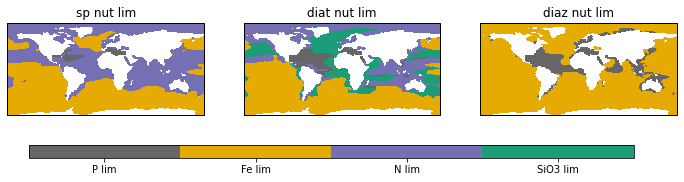

In [5]:
fig = plt.figure(figsize=(12,3.5))

ocn_mask = np.where(np.isnan(datasets['sp']['sp_lim'].isel(nutrient=0).data), False, True)
levels = np.arange(5)
norm = colors.BoundaryNorm(levels, ncolors=4)
for n, autotroph in enumerate(['sp', 'diat', 'diaz']):
    ds = datasets[autotroph]
    da = ds[f'{autotroph}_lim']
    ax = fig.add_subplot(1,3,n+1, projection=ccrs.PlateCarree())
    ax.set_title(f'{autotroph} nut lim', fontsize=12)
    pc = ax.pcolormesh(ds['TLONG'].data,
                       ds['TLAT'].data,
                       da.argmin(dim='nutrient', skipna=False).where(ocn_mask).data,
                       norm=norm,
                       cmap=plt.cm.get_cmap('Dark2_r', 4),
                       transform=ccrs.PlateCarree())

# fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.15, 0.15, 0.7, 0.05])
cbar = fig.colorbar(pc, cax=cbar_ax, ticks=levels+.5, orientation='horizontal')
cbar.ax.set_xticklabels([f'{nutrient} lim' for nutrient in nutrients]);